In [33]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# first time only—downloads the WordNet data to your default nltk_data folder
nltk.download('wordnet')    
# also grab the multilingual word database (often needed)
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\praka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\praka\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [34]:
df = pd.read_csv(filepath_or_buffer=r"D:\Programming\MLOPS ROOT\IMBD-Review-Sentiment-Pipeline\notebooks\IMDB Dataset.csv")
# df = df.sample(1000)
# df.to_csv(r"D:\Programming\MLOPS ROOT\Capstone-Project\notebooks\sample-data.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


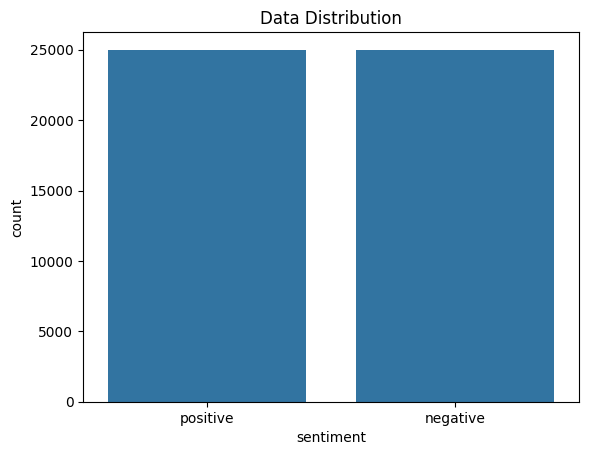

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x="sentiment", data=df) 
plt.title("Data Distribution")
plt.show()

# Data Preprocessing

In [3]:

# Define text preprocessing functions
def lemmatization(text):
    """
    Lemmatize the text
    Think of lemmatization like finding a word’s “dictionary form.” It’s like this:

    * You start with a word that might be changed by tense, number, or form:

    * running, ran, runs → run
    * better → good
    * geese → goose

    * A lemmatizer looks up or reasons what the base word is (the “lemma”) instead of just chopping off endings.

    So, in plain terms: **lemmatization** turns words into their simplest, real-word form so that all the different versions (“runs,” “running,” “ran”) become just “run.” That way, when you analyze text, you treat them as the same word.
    """
    lemmatizer = WordNetLemmatizer()
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(text)

def remove_stop_words(text):
    """Remove stop words from the text.
    Stop words are the most common words in a language that carry very little semantic meaning 
    on their own—words like “a,” “an,” “the,” “in,” “on,” “and,” “but,” etc. 
    In many natural-language processing (NLP) tasks, these words are removed (or “filtered out”) before analysis
    to reduce noise and focus on the more meaningful words.
    """
    stop_word = set(stopwords.words("english")) 
    text = [word for word in text.split() if word not in stop_word]
    return " ".join(text)

def remove_numbers(text):
    """Remove numbers from the text."""
    return " ".join([word for word in text.split() if not word.isdigit()])    

def lower_case(text):
    """Convert text to lower case."""
    text = [word.lower() for word in text.split()]
    return " ".join(text)

def remove_urls(text):
    """Remove URLs from the text."""
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def normalize_text(df):
    """Normalize the text data."""
    try:
        df['review'] = df['review'].apply(remove_stop_words)
        df['review'] = df['review'].apply(remove_numbers)
        df['review'] = df['review'].apply(remove_urls)
        df['review'] = df['review'].apply(lower_case)
        df['review'] = df['review'].apply(lemmatization)
        return df
    except Exception as e:
        print(f'Error during text normalization: {e}')
        raise 
def normalize_text_wt_rm_numbers(df):
    """Normalize the text data."""
    try:
        df['review'] = df['review'].apply(remove_stop_words)
        df['review'] = df['review'].apply(remove_numbers)
        df['review'] = df['review'].apply(remove_urls)
        df['review'] = df['review'].apply(lower_case)
        df['review'] = df['review'].apply(lemmatization)
        return df
    except Exception as e:
        print(f'Error during text normalization: {e}')
        raise 



In [4]:
# Preproccessing text(Cleaning the text)
df = normalize_text(df)
# df = normalize_text_wt_rm_numbers(df=df)
df.head()


,review,sentiment
42086,this film favorite comedy time i seen lot come...,positive
12986,"actually, i narrating main plot comment 2-3 se...",negative
2951,"it seems like exciting prospect, modern-dress ...",negative
49157,this one best presentation 60's put film. arth...,positive
26537,"i went cinema two friends, picked movie hat, t...",positive


In [5]:
# Checking distribution of data
df['sentiment'].value_counts()

sentiment
negative    515
positive    485
Name: count, dtype: int64

In [6]:
# Eliminating any other category than 'positive' and 'negative'
x = df['sentiment'].isin(['positive','negative'])
df = df[x]

In [7]:
# Encoding 'positve'to '1' and 'negative' to '0'
df['sentiment'] = df['sentiment'].map({'positive':1,'negative':0})
df.head()

,review,sentiment
42086,this film favorite comedy time i seen lot come...,1
12986,"actually, i narrating main plot comment 2-3 se...",0
2951,"it seems like exciting prospect, modern-dress ...",0
49157,this one best presentation 60's put film. arth...,1
26537,"i went cinema two friends, picked movie hat, t...",1


In [8]:
# Checking null values
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [9]:
## Vectorization


# In the context of text-based machine learning, **vectorization** means turning words or whole 
# documents into numeric vectors (lists of numbers) so that algorithms—which only understand numbers—can work on them.

# ---

# ### Why vectorize?

# * Computers can’t do math on raw text.
# * By mapping text to numbers, you can feed it into models like logistic regression, SVMs, or neural networks.

# ---

# ### Common approaches

# 1. **Bag-of-Words (BoW)**

#    * Build a vocabulary of all unique words in your corpus.
#    * Represent each document as a vector whose length is the vocab size, where each position 
#      counts how often that vocab word appears.
#    * Example for vocab `[“cat”, “dog”, “mouse”]`:

#      * “cat and dog” → `[1, 1, 0]`
#      * “dog dog dog” → `[0, 3, 0]`

# 2. **TF-IDF (Term Frequency–Inverse Document Frequency)**

#    * Similar to BoW, but weights each count by how “rare” a word is across all documents.
#    * Common words (“the”, “and”) get down-weighted, rarer words get up-weighted.

# 3. **Word Embeddings**

#    * Pretrained methods (Word2Vec, GloVe, fastText) map each word to a dense, low-dimensional 
#      vector (e.g. 100–300 dimensions) that captures semantic similarity.
#    * “king” and “queen” end up close together in this vector space.

# 4. **Document Embeddings**

#    * Extend embeddings to whole sentences or documents (Doc2Vec, averaging word vectors, transformer 
#      outputs like BERT’s CLS token).

# ### In a nutshell

# **Vectorization** converts text into a structured, numeric form—whether simple counts, weighted scores,
#   or dense embeddings—so you can apply mathematical models to understand and predict from natural language.

vectorizer = CountVectorizer(max_features=100)
X = vectorizer.fit_transform(df['review'])
Y = df['sentiment']

In [10]:
# Train-Test-Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [11]:
# Setting up experimentation with Dagshub and Mlflow
import dagshub
import mlflow
import mlflow.sklearn
from var import MLFLOW_TRACKING_URI, DAGSHUB_REPO_OWNER, DAGSHUB_REPO_NAME
mlflow_uri = MLFLOW_TRACKING_URI
repo_owner = DAGSHUB_REPO_OWNER
repo_name = DAGSHUB_REPO_NAME
mlflow.set_tracking_uri(mlflow_uri)# Setting URI of remote tracking server
dagshub.init(repo_owner=repo_owner,repo_name=repo_name,mlflow=True)
mlflow.set_experiment("Logistic Regression Baseline")


Accessing as PrakashD2003

Initialized MLflow to track repo "PrakashD2003/Capstone-Project"

Repository PrakashD2003/Capstone-Project initialized!

<Experiment: artifact_location='mlflow-artifacts:/10511b97138d4cceaf9b0387aa4d28d8', creation_time=1746296173786, experiment_id='0', last_update_time=1746296173786, lifecycle_stage='active', name='Logistic Regression Baseline', tags={}>

In [12]:
import logging
import time
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Congigure basic logger
logging.basicConfig(level=logging.INFO,format="%(asctime)s - %(levelname)s - %(message)s")
logging.info("Starting Mlflow run...")

with mlflow.start_run():
    try:
        start_time = time.time()
        logging.info("Logging Preproccessing Parameters...")
        mlflow.log_params(params={"vectorizer":"Bag of Word",
                                  "max_features_vectorizer":100,
                                  "remove_numbers":True,
                                  "test_size":0.25
                                  })
        
        logging.info("Initializing Logistic Regression model...")
        model  = LogisticRegression(max_iter=1000)

        logging.info("Fitting the model...")
        model.fit(X_train, Y_train)
        logging.info("Model training complete.")
        logging.info("Logging model parameters...")
        mlflow.log_params(params={"model":"Logistic Regression",
                                  "max_iter_logistic_reg":1000})
        
        logging.info("Making Prediction")
        Y_pred = model.predict(X_test)

        logging.info("Calculating evaluation metrics...")
        accuracy = accuracy_score(y_true=Y_test,y_pred=Y_pred)
        precision = precision_score(y_true=Y_test,y_pred=Y_pred)
        recall = recall_score(y_true=Y_test,y_pred=Y_pred)
        f1 = f1_score(y_true=Y_test,y_pred=Y_pred)

        logging.info("Logging evaluation metrics...")
        mlflow.log_metrics(metrics={"Accuracy_Score":accuracy,
                                    "Precision_Score":precision,
                                    "Recall_Score":recall,
                                    "F1_Score":f1})
        
        logging.info("Saving and logging the model...")
        mlflow.sklearn.log_model(model, "model")

        # Log execution time
        end_time = time.time()
        logging.info(f"Model training and logging completed in {end_time - start_time:.2f} seconds.")

        logging.info("Saving this notebook as artifact...")
        notebook_path = "exp1.ipynb"
        mlflow.log_artifact(local_path= notebook_path, artifact_path="notebooks")

        # Print the results for verification
        logging.info(f"Accuracy: {accuracy}")
        logging.info(f"Precision: {precision}")
        logging.info(f"Recall: {recall}")
        logging.info(f"F1 Score: {f1}")

    except Exception as e:
        logging.error(f"An error occurred: {e}", exc_info=True)


2025-05-12 21:34:09,904 - INFO - Starting Mlflow run...
2025-05-12 21:34:10,389 - INFO - Logging Preproccessing Parameters...
2025-05-12 21:34:10,770 - INFO - Initializing Logistic Regression model...
2025-05-12 21:34:10,771 - INFO - Fitting the model...
2025-05-12 21:34:10,796 - INFO - Model training complete.
2025-05-12 21:34:10,797 - INFO - Logging model parameters...
2025-05-12 21:34:11,172 - INFO - Making Prediction
2025-05-12 21:34:11,173 - INFO - Calculating evaluation metrics...
2025-05-12 21:34:11,179 - INFO - Logging evaluation metrics...
2025-05-12 21:34:11,588 - INFO - Saving and logging the model...
2025/05/12 21:34:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-05-12 21:34:21,109 - INFO - Model training and logging completed in 10.72 seconds.
2025-05-12 21:34:21,110 - INFO - Saving this notebook as artifact...
2025-05-12 21:34:21,633 - I

🏃 View run salty-foal-318 at: https://dagshub.com/PrakashD2003/Capstone-Project.mlflow/#/experiments/0/runs/906191124d3247609696ef3d2393b9f6
🧪 View experiment at: https://dagshub.com/PrakashD2003/Capstone-Project.mlflow/#/experiments/0
